In [17]:
import numpy as np
import scipy
from sympy import *

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (8,6)

### Полный проход списка, состоящего из вложенных список

In [2]:
def traverse_list(ls, a):
    if type(ls) == tuple:
        if ls[0] != 0 or ls[1] != 0:
            a.append(ls)
        return
    for i in range(len(ls)):
        traverse_list(ls[i], a)

In [3]:
def get_clean_intervals(ls, a):
    traverse_list(ls, a)
    return a

### Составление ряда Штурмана

In [4]:
def get_sturm_row(equation):
    x, y = symbols('x y')
    sturm_row = list()
    y = equation
    sturm_row.append(y)

    y_2 = diff(y)
    sturm_row.append(y_2)

    r = y_2
    while degree(r) > 0:
        r = div(y, y_2)[1] * (-1)  # get remain
        sturm_row.append(r)
        y = y_2
        y_2 = r
    return sturm_row

### Находим на большом интервале интервалы с всего одним коренем

In [5]:
def get_1root_intervals(sturm_row, interval: tuple):
    root_intervals = list()
    digit_change_times = dict()
    for i in range(interval[0], interval[1] + 1):
        func_values = list()
        digit_changes_count = 0
        for num, func in enumerate(sturm_row):
            func_values.append(func.subs('x', i))
            if num == 0:
                continue
            if func_values[num] * func_values[num - 1] < 0:
                digit_changes_count += 1

        digit_change_times[i] = digit_changes_count

    for i in range(interval[0] + 1, interval[1] + 1):

        if digit_change_times[i - 1] - digit_change_times[i] > 1:
            result_intervals = get_1root_small_interval(sturm_row, (i - 1, i))
            clean_upped_intervals = []
            clean_upped_intervals = get_clean_intervals(result_intervals, clean_upped_intervals)

            for inter in clean_upped_intervals:
                root_intervals.append(list(inter))

        elif digit_change_times[i - 1] != digit_change_times[i]:
            root_intervals.append([i - 1, i])

    for i in range(1, len(root_intervals)):
        if root_intervals[i][0] == root_intervals[i - 1][1]:
            root_intervals[i][0] = root_intervals[i][0] + 0.00001

    return root_intervals


### Разбиваем маленькие интервалы с несколькими корнями на интервалы с 1 корнем

In [6]:
def get_1root_small_interval(sturm_row, interval: tuple):
    result_intervals = []
    digit_changes = [0, 0]

    for inter_num, inter in enumerate(interval):
        func_values = list()
        prev_val = 0
        current_val = 0
        for i, func in enumerate(sturm_row):
            func_values.append(func.subs('x', inter))

            if i == 0:
                prev_val = func_values[i]
                continue
            current_val = func_values[i]

            if prev_val == 0:
                prev_val = current_val
                continue
            if current_val == 0:
                continue

            if prev_val * current_val < 0:
                digit_changes[inter_num] += 1
            prev_val = current_val

    if digit_changes[0] == digit_changes[1]:
        return 0, 0

    if abs(digit_changes[1] - digit_changes[0]) == 1:
        return interval[0], interval[1]
    else:
        middle = float(interval[1] - interval[0]) / 2
        result_intervals.append(get_1root_small_interval(sturm_row, (interval[0], interval[0] + middle)))
        result_intervals.append(get_1root_small_interval(sturm_row, (interval[0] + middle, interval[1])))

    return result_intervals

### Метод биссекции 

In [7]:
def bisection(function, interval: tuple, tol=0.0001):
    x, y = symbols('x y')
    a, b = interval[0], interval[1]
    mid = (a + b) / 2

    f = lambdify(x, function, "numpy")

    if f(a) * f(b) > 0:
        raise Exception(f"Bisection method couldn't solve f(x) = 0, because f(a) * f(b) = {f(a) * f(b)} >= 0\n"
                        f"--> more than 1 root on ({(a, b)}) or no roots)")
    x_delta = tol * 2
    iteration = 1
    while f(mid) > tol or x_delta > tol:
        if f(a) == 0:
            return a, iteration
        elif f(b) == 0:
            return b, iteration
        elif f(mid) == 0:
            return mid, iteration

        if f(a) * f(mid) < 0:
            b = mid
        elif f(b) * f(mid) < 0:
            a = mid

        x_delta = mid
        mid = (a + b) / 2

        x_delta = abs(x_delta - mid)
        iteration += 1

    return mid, iteration

### Метод хорд

In [8]:
def secant(function, interval: tuple, tol=0.0001):
    x, y = symbols('x y')
    a, b = interval[0], interval[1]
    f = lambdify(x, function, "numpy")
    if f(a) * f(b) > 0:
        raise Exception(f"Secant method couldn't solve f(x) = 0, because f(a) * f(b) = {f(a) * f(b)} >= 0\n"
                        f"--> more than 1 root on ({(a, b)}) or no roots)")

    x_sec = a - (f(a) * (b - a)) / (f(b) - f(a))

    x_delta = 0
    iteration = 1
    while abs(f(x_sec)) > tol or x_delta > tol:
        if f(a) == 0:
            return a, iteration
        elif f(b) == 0:
            return b, iteration
        elif f(x_sec) == 0:
            return x_sec, iteration

        if f(x_sec) * f(a) < 0:
            b = x_sec
        elif f(x_sec) * f(b) < 0:
            a = x_sec

        x_delta = x_sec
        x_sec = a - (f(a) * (b - a)) / (f(b) - f(a))

        x_delta = abs(x_delta - x_sec)
        iteration += 1

    return x_sec, iteration


### Метод Ньютона (касательных)


In [10]:
def newton(function, interval, tol=0.0001):
    x, y = symbols('x y')
    a, b = interval[0], interval[1]
    f = lambdify(x, function, 'numpy')

    if f(a) * f(b) > 0:
        raise Exception(f"Newton method couldn't solve f(x) = 0, because f(a) * f(b) = {f(a) * f(b)} >= 0\n"
                        f"--> more than 1 root on ({(a, b)}) or no roots)")

    x_start = (a + b) / 2
    y_diff = function.diff()
    f_diff = lambdify(x, y_diff, 'numpy')

    x_newton = x_start - f(x_start) / f_diff(x_start)

    x_delta = tol * 2
    iteration = 1
    while abs(f(x_newton)) > tol or x_delta > tol:
        if f(x_newton) == 0:
            return x_newton, iteration

        x_delta = x_newton
        x_newton = x_newton - f(x_newton) / f_diff(x_newton)
        x_delta = abs(x_delta - x_newton)
        iteration += 1

    return x_newton, iteration


In [11]:
def separator():
    for i in range(2):
        print('-' * 50)

In [18]:
x = symbols('x')

### Тестовый пример 1

Количиство корней на интервале (-10, 10): 2
Интервалы в которыx находится ровно один корень: [[-1, 0], [1, 2]]

		Рассматриваемый интервал: [-1, 0]

*** Метод Биссекции (Половинного деления) ***
Корень: -0.29998779296875
Количество Итераций: 14

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: -0.2999606066662447
Количество Итераций: 8
--------------------------------------------------
--------------------------------------------------
*** Метод Ньютона (Касательных) ***
Корень: -0.30000000000000204
Количество Итераций: 4

		Рассматриваемый интервал: [1, 2]

*** Метод Биссекции (Половинного деления) ***
Корень: 1.20001220703125
Количество Итераций: 14

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: 1.1999505620110387
Количество Итераций: 8
--------------------------------------------------
-----------------

x**2 - 0.9*x - 0.36

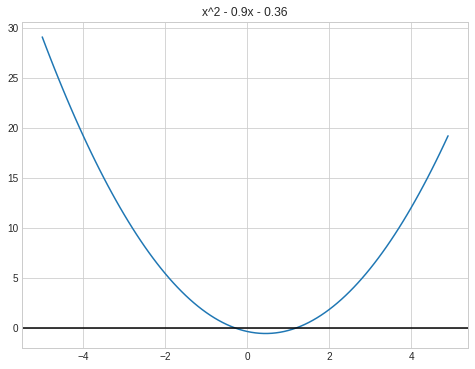

In [19]:
y = x**2 - 0.9*x - 0.36
interval = (-10, 10)

x_1 = np.arange(-5, 5, 0.1)
y_1 = x_1**2 - 0.9*x_1 - 0.36
fig, ax = plt.subplots()
ax.plot(x_1, y_1)
ax.axhline(y=0, color='k');
plt.title("x^2 - 0.9x - 0.36");

intervals = get_1root_intervals(get_sturm_row(y), interval)
print(f'Количиство корней на интервале (-10, 10): {len(intervals)}')
print(f'Интервалы в которыx находится ровно один корень: {[i for i in intervals]}')
for interval in intervals:
    print(f"\n\t\tРассматриваемый интервал: {interval}\n")
    bisection_ans = bisection(y, interval)
    secant_ans = secant(y, interval)
    newton_ans = newton(y, interval)
    print(f"*** Метод Биссекции (Половинного деления) ***\n"
          f"Корень: {bisection_ans[0]}\n"
          f"Количество Итераций: {bisection_ans[1]}\n")
    separator()
    print(f"*** Метод Секущих (Хорд) ***\n"
          f"Корень: {secant_ans[0]}\n"
          f"Количество Итераций: {secant_ans[1]}")
    separator()
    print(f"*** Метод Ньютона (Касательных) ***\n"
          f"Корень: {newton_ans[0]}\n"
          f"Количество Итераций: {newton_ans[1]}")
y

### Тестовый пример 2

Количиство корней на интервале (-10, 10): 1
Интервалы в которыx находится ровно один корень: [[-3, -2]]

		Рассматриваемый интервал: [-3, -2]

*** Метод Биссекции (Половинного деления) ***
Корень: -2
Количество Итераций: 1

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: -2.0
Количество Итераций: 1
--------------------------------------------------
--------------------------------------------------
*** Метод Ньютона (Касательных) ***
Корень: -2.00006103515625
Количество Итераций: 13


(2*x + 4)**2

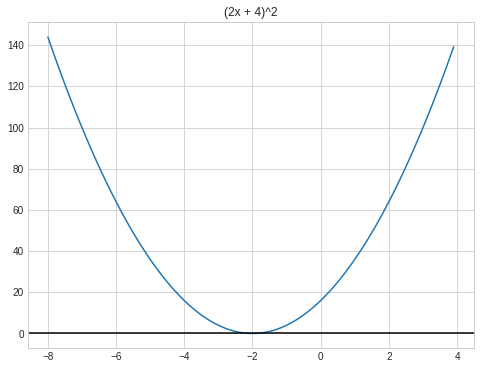

In [20]:
y = (2*x + 4)**2
interval = (-10, 10)

x_2 = np.arange(-8, 4, 0.1)
y_2 = (2*x_2 + 4)**2
fig, ax = plt.subplots()
ax.plot(x_2, y_2)
ax.axhline(y=0, color='k');
plt.title("(2x + 4)^2");

intervals = get_1root_intervals(get_sturm_row(y), interval)
print(f'Количиство корней на интервале (-10, 10): {len(intervals)}')
print(f'Интервалы в которыx находится ровно один корень: {[i for i in intervals]}')
for interval in intervals:
    print(f"\n\t\tРассматриваемый интервал: {interval}\n")
    bisection_ans = bisection(y, interval)
    secant_ans = secant(y, interval)
    newton_ans = newton(y, interval)
    print(f"*** Метод Биссекции (Половинного деления) ***\n"
          f"Корень: {bisection_ans[0]}\n"
          f"Количество Итераций: {bisection_ans[1]}\n")
    separator()
    print(f"*** Метод Секущих (Хорд) ***\n"
          f"Корень: {secant_ans[0]}\n"
          f"Количество Итераций: {secant_ans[1]}")
    separator()
    print(f"*** Метод Ньютона (Касательных) ***\n"
          f"Корень: {newton_ans[0]}\n"
          f"Количество Итераций: {newton_ans[1]}")

y

### Тестовый пример 3

Количиство корней на интервале (-10, 10): 4
Интервалы в которыx находится ровно один корень: [[-3, -2], [-1, 0], [1, 2], [3, 4]]

		Рассматриваемый интервал: [-3, -2]

*** Метод Биссекции (Половинного деления) ***
Корень: -2.35003662109375
Количество Итераций: 14

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: -2.350082809843179
Количество Итераций: 14
--------------------------------------------------
--------------------------------------------------
*** Метод Ньютона (Касательных) ***
Корень: -2.3500847963187756
Количество Итераций: 4

		Рассматриваемый интервал: [-1, 0]

*** Метод Биссекции (Половинного деления) ***
Корень: -0.11407470703125
Количество Итераций: 14

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: -0.11401153728200486
Количество Итераций: 7
----------------------------------------------

x**4 - 2*x**3 - 7*x**2 + 8*x + 1

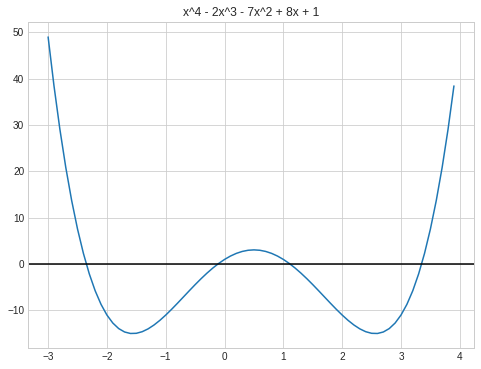

In [21]:
y = x**4 - 2*x**3 - 7*x**2 + 8*x + 1
interval = (-10, 10)

x_3 = np.arange(-3, 4, 0.1)
y_3 = x_3**4 - 2*x_3**3 - 7*x_3**2 + 8*x_3 + 1
fig, ax = plt.subplots()
ax.plot(x_3, y_3)
ax.axhline(y=0, color='k');
plt.title("x^4 - 2x^3 - 7x^2 + 8x + 1");

intervals = get_1root_intervals(get_sturm_row(y), interval)
print(f'Количиство корней на интервале (-10, 10): {len(intervals)}')
print(f'Интервалы в которыx находится ровно один корень: {[i for i in intervals]}')
for interval in intervals:
    print(f"\n\t\tРассматриваемый интервал: {interval}\n")
    bisection_ans = bisection(y, interval)
    secant_ans = secant(y, interval)
    newton_ans = newton(y, interval)
    print(f"*** Метод Биссекции (Половинного деления) ***\n"
          f"Корень: {bisection_ans[0]}\n"
          f"Количество Итераций: {bisection_ans[1]}\n")
    separator()
    print(f"*** Метод Секущих (Хорд) ***\n"
          f"Корень: {secant_ans[0]}\n"
          f"Количество Итераций: {secant_ans[1]}")
    separator()
    print(f"*** Метод Ньютона (Касательных) ***\n"
          f"Корень: {newton_ans[0]}\n"
          f"Количество Итераций: {newton_ans[1]}")
y

### Тестовый пример 4

Количиство корней на интервале (-10, 10): 5
Интервалы в которыx находится ровно один корень: [[-10, -9], [-8, -7], [2, 3], [3.00001, 4], [7, 8]]

		Рассматриваемый интервал: [-10, -9]

*** Метод Биссекции (Половинного деления) ***
Корень: -9.20001220703125
Количество Итераций: 14

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: -9.19999999013451
Количество Итераций: 18
--------------------------------------------------
--------------------------------------------------
*** Метод Ньютона (Касательных) ***
Корень: -9.200000005308917
Количество Итераций: 4

		Рассматриваемый интервал: [-8, -7]

*** Метод Биссекции (Половинного деления) ***
Корень: -7.199981689453125
Количество Итераций: 15

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: -7.200000000542465
Количество Итераций: 6
-------------------------------

x**5 + 2.66*x**4 - 104.5099*x**3 - 81.435104*x**2 + 2525.02674*x - 4405.59219

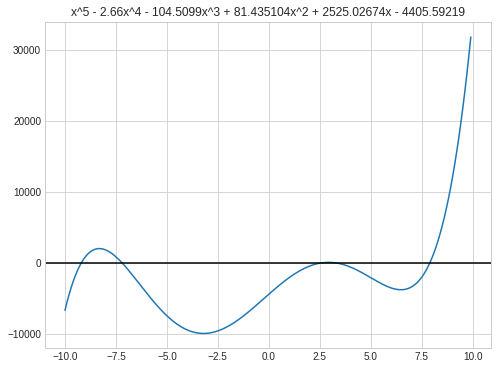

In [24]:
y = x**5 + 2.66*x**4 - 104.5099*x**3 - 81.435104*x**2 + 2525.02674*x - 4405.59219

interval = (-10, 10)

x_4 = np.arange(-10, 10, 0.1)
y_4 = x_4**5 + 2.66*x_4**4 - 104.5099*x_4**3 - 81.435104*x_4**2 + 2525.02674*x_4 - 4405.59219
fig, ax = plt.subplots()
ax.plot(x_4, y_4)
ax.axhline(y=0, color='k');
plt.title("x^5 - 2.66x^4 - 104.5099x^3 + 81.435104x^2 + 2525.02674x - 4405.59219");

intervals = get_1root_intervals(get_sturm_row(y), interval)
print(f'Количиство корней на интервале (-10, 10): {len(intervals)}')
print(f'Интервалы в которыx находится ровно один корень: {[i for i in intervals]}')
for interval in intervals:
    print(f"\n\t\tРассматриваемый интервал: {interval}\n")
    bisection_ans = bisection(y, interval)
    secant_ans = secant(y, interval)
    newton_ans = newton(y, interval)
    print(f"*** Метод Биссекции (Половинного деления) ***\n"
          f"Корень: {bisection_ans[0]}\n"
          f"Количество Итераций: {bisection_ans[1]}\n")
    separator()
    print(f"*** Метод Секущих (Хорд) ***\n"
          f"Корень: {secant_ans[0]}\n"
          f"Количество Итераций: {secant_ans[1]}")
    separator()
    print(f"*** Метод Ньютона (Касательных) ***\n"
          f"Корень: {newton_ans[0]}\n"
          f"Количество Итераций: {newton_ans[1]}")
y

### Тестовый пример 5

Количиство корней на интервале (-10, 10): 5
Интервалы в которыx находится ровно один корень: [[-10, -9], [-8, -7], [2, 3], [3.00001, 4], [7, 8]]

		Рассматриваемый интервал: [-10, -9]

*** Метод Биссекции (Половинного деления) ***
Корень: -9.20001220703125
Количество Итераций: 14

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: -9.19999999013451
Количество Итераций: 18
--------------------------------------------------
--------------------------------------------------
*** Метод Ньютона (Касательных) ***
Корень: -9.200000005308917
Количество Итераций: 4

		Рассматриваемый интервал: [-8, -7]

*** Метод Биссекции (Половинного деления) ***
Корень: -7.199981689453125
Количество Итераций: 15

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: -7.200000000542465
Количество Итераций: 6
-------------------------------

x**5 + 2.66*x**4 - 104.5099*x**3 - 81.435104*x**2 + 2525.02674*x - 4405.59219

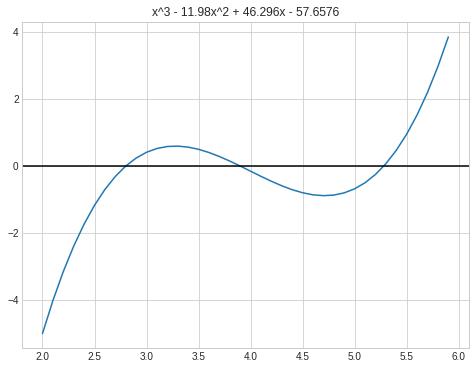

In [25]:

interval = (-10, 10)

x_5 = np.arange(2, 6, 0.1)
y_5 = x_5**3 - 11.98*x_5**2 + 46.296*x_5 - 57.6576
fig, ax = plt.subplots()
ax.plot(x_5, y_5)
ax.axhline(y=0, color='k');
plt.title("x^3 - 11.98x^2 + 46.296x - 57.6576");

intervals = get_1root_intervals(get_sturm_row(y), interval)
print(f'Количиство корней на интервале (-10, 10): {len(intervals)}')
print(f'Интервалы в которыx находится ровно один корень: {[i for i in intervals]}')
for interval in intervals:
    print(f"\n\t\tРассматриваемый интервал: {interval}\n")
    bisection_ans = bisection(y, interval)
    secant_ans = secant(y, interval)
    newton_ans = newton(y, interval)
    print(f"*** Метод Биссекции (Половинного деления) ***\n"
          f"Корень: {bisection_ans[0]}\n"
          f"Количество Итераций: {bisection_ans[1]}\n")
    separator()
    print(f"*** Метод Секущих (Хорд) ***\n"
          f"Корень: {secant_ans[0]}\n"
          f"Количество Итераций: {secant_ans[1]}")
    separator()
    print(f"*** Метод Ньютона (Касательных) ***\n"
          f"Корень: {newton_ans[0]}\n"
          f"Количество Итераций: {newton_ans[1]}")
y

### Задание

Количиство корней на интервале (-10, 10): 2
Интервалы в которыx находится ровно один корень: [[4, 5], [8, 9]]

		Рассматриваемый интервал: [4, 5]

*** Метод Биссекции (Половинного деления) ***
Корень: 4.1392669677734375
Количество Итераций: 16

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: 4.139264584195006
Количество Итераций: 4
--------------------------------------------------
--------------------------------------------------
*** Метод Ньютона (Касательных) ***
Корень: 4.1392640717946385
Количество Итераций: 4

		Рассматриваемый интервал: [8, 9]

*** Метод Биссекции (Половинного деления) ***
Корень: 8.437500953674316
Количество Итераций: 20

--------------------------------------------------
--------------------------------------------------
*** Метод Секущих (Хорд) ***
Корень: 8.43750074917939
Количество Итераций: 7
--------------------------------------------------
-----------------------

x**3 + 9.57496*x**2 - 243.672*x + 773.65

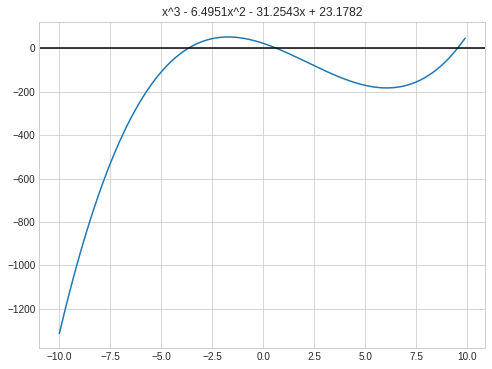

In [34]:
y = x**3 + 9.57496*x**2 - 243.672*x + 773.65

interval = (-10, 10)

x_task = np.arange(-10, 10, 0.1)
y_task = x_task**3 -6.4951*x_task**2 - 31.2543*x_task + 23.1782
fig, ax = plt.subplots()
ax.plot(x_task, y_task)
ax.axhline(y=0, color='k');
plt.title("x^3 - 6.4951x^2 - 31.2543x + 23.1782");

intervals = get_1root_intervals(get_sturm_row(y), interval)
print(f'Количиство корней на интервале (-10, 10): {len(intervals)}')
print(f'Интервалы в которыx находится ровно один корень: {[i for i in intervals]}')
for interval in intervals:
    print(f"\n\t\tРассматриваемый интервал: {interval}\n")
    bisection_ans = bisection(y, interval)
    secant_ans = secant(y, interval)
    newton_ans = newton(y, interval)
    print(f"*** Метод Биссекции (Половинного деления) ***\n"
          f"Корень: {bisection_ans[0]}\n"
          f"Количество Итераций: {bisection_ans[1]}\n")
    separator()
    print(f"*** Метод Секущих (Хорд) ***\n"
          f"Корень: {secant_ans[0]}\n"
          f"Количество Итераций: {secant_ans[1]}")
    separator()
    print(f"*** Метод Ньютона (Касательных) ***\n"
          f"Корень: {newton_ans[0]}\n"
          f"Количество Итераций: {newton_ans[1]}")
separator()
correct_root = np.roots([1, 9.57496, - 243.672, 773.65])
print(f'**** Solving with Nampy ****\n'
          f'ROOTS: {correct_root}\n')
y